# 任务一 CNN手绘图像分类

## 1.1 读入图像并展示
1. 每类展示10个样本图像
2. 将‘ambulance’,‘apple’,‘bear’,‘bicycle’,‘bird’,‘bus’,‘cat’ 7个类的数据，每类按照7:2:1划分为“训练集”、“验证集”和“分布内测试集（IN-test）”
3. 将‘foot’,‘owl’,‘pig‘作为“分布外数据集”，每类抽取100张图像构成“分布外测试数据集（OOD-test）

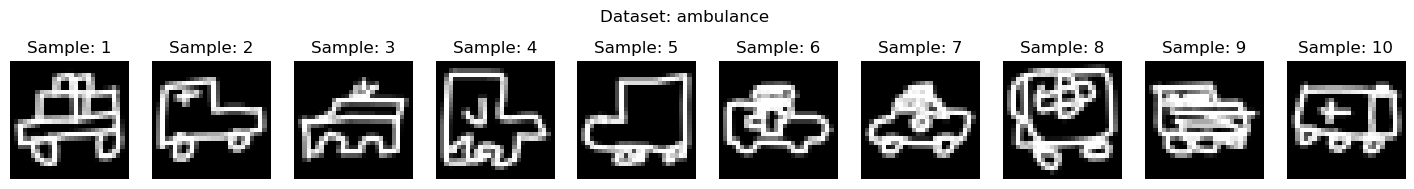

In [36]:
import numpy as np
import matplotlib.pyplot as plt


def read_and_show_data(path, dataset_name, show_num):
    file = np.load(path + '/' + dataset_name + '/' + dataset_name + '.npy')

    # 从数组中随机抽取3个元素的索引
    random_indices = np.random.choice(len(file), show_num, replace=False)
    # 根据索引获取相应的元素
    random_samples = file[random_indices]  

    # 绘图
    plt.figure(figsize=(18, 4))
    for i in range(show_num):
        plt.subplot(2, 10, i + 1) 

        image = random_samples[i].reshape(28, 28)

        plt.imshow(image, cmap='gray')
        plt.title(f"Sample: {i+1}")
        plt.axis('off')

    plt.suptitle(f"Dataset: {dataset_name}")
    plt.show()

    return file.tolist()

# 标签定义
label = {0:'ambulance', 1:'apple'}

all_data = []

all_data.append(read_and_show_data('./2023-GAI-实验4-图像数据集', 'ambulance', 10))
all_data.append(read_and_show_data('./2023-GAI-实验4-图像数据集/', 'apple', 10))


In [37]:
# 分割数据集
import numpy


train_x = []
train_y = []
val_x = []
val_y = []
test_x_in = []
test_y_in = []
test_x_out = []
test_y_out = []


for i in range(len(all_data)):
    total_length = len(all_data[i])

    # 分布外数据集
    if i >= 7:
        test_x_out.extend(np.random.choice(all_data[i], 100, replace=False))
        test_y_out.extend([i]*total_length)

    # 分布内数据集
    else:
        split1 = int(total_length * 0.7)
        split2 = int(total_length * 0.9)

        train_x.extend(all_data[i][:split1])
        train_y.extend([i]*split1)
        val_x.extend(all_data[i][split1:split2])
        val_y.extend([i]*split2)
        test_x_in.extend(all_data[i][split2:])
        test_y_in.extend([i]*(total_length - split2))


print(np.array(train_x).shape)
print(np.array(train_x))

print(np.array(train_y).shape)
print(np.array(train_y))

(14000, 784)
[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]
(14000,)
[0 0 0 ... 0 0 0]
